In [1]:
import pandas as pd
import numpy as np
import os
from datetime import datetime
import calendar

In [2]:
%load_ext rpy2.ipython

In [3]:
%R library(ggplot2)

array(['ggplot2', 'tools', 'stats', 'graphics', 'grDevices', 'utils',
       'datasets', 'methods', 'base'], dtype='<U9')

In [4]:
dfbart = pd.read_csv('bart_data.csv')

In [5]:
# identify list of desired stations

In [6]:
desired_stations = ['16th Street Mission', '24th Street Mission', 'Embarcadero', 'Montgomery Street', 'Powell Street', 'Civic Center', 'Glen Park', 'Balboa Park']

In [7]:
# the excel file below includes full names of stations, which I want to merger using the index of station abreviations under "Unnamed: 0.1".

In [8]:
df_station_names = pd.read_excel("/Users/maxine/Documents/GitHub/Visualization/Station_Names.xlsx")

In [9]:
df_stations = df_station_names[['Two-Letter Station Code', 'Station Name']]
df_stations.columns = ['Unnamed: 0.1','Station Name']

In [10]:
df_stations['Unnamed: 0.1'] = df_stations['Unnamed: 0.1'].astype(str).unique()

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [11]:
df_bart_station_name = pd.merge(dfbart, df_stations, how='left',on='Unnamed: 0.1')

In [12]:
# df_bart incldues only stations that are in the desired_stations list.

In [13]:
df_bart = df_bart_station_name.loc[(df_bart_station_name['Station Name'].isin(desired_stations))]

In [14]:
# Assign neighborhoods (from crime 2019 data) to each station exit at bart.

In [15]:
desired_stations_dictionary = {'16th Street Mission': 'Mission' , '24th Street Mission':'Mission', 'Embarcadero' :'Financial District/South Beach', 'Montgomery Street':'Financial District/South Beach', 'Powell Street':'Financial District/South Beach', 'Civic Center':'Tenderloin', 'Glen Park':'Glen Park', 'Balboa Park': 'Oceanview/Merced/Ingleside'}

In [16]:
neighborhood_ls = list(desired_stations_dictionary.values())

In [17]:
# created Neighborhood column in dataframe

In [18]:
df_bart['Neighborhood'] = df_bart['Station Name'].map(desired_stations_dictionary)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [19]:
df_crime_2019=pd.read_csv('Safety_on_bart/crime_2019.csv', parse_dates=['Incident Datetime'])

In [20]:
# the crux of merging. Neighborhoods are carefully selected and named so that crime and bart neighborhoods match.

In [21]:
df_sorted_crime = df_crime_2019.loc[(df_crime_2019['Analysis Neighborhood'].isin(neighborhood_ls))]

In [22]:
crimes_of_interest = ["Lost Property", "Assault", "Robbery", "Drug Offense", "Disorderly Conduct", "Arson", "Weapons Carrying Etc", "Weapons Offense", "Sex Offense", "Stolen Property"]
#, "Weapons Offence"

In [23]:
# interested in only weekday data with the list of crimes_of_interest

In [24]:
df_sorted_crime_for_merging = df_sorted_crime.loc[(df_sorted_crime['Incident Category'].isin(crimes_of_interest)) & (df_sorted_crime['WEEKDAY'] ==1)]

In [25]:
df_sorted_crime_for_merging = df_sorted_crime_for_merging.loc[df_sorted_crime_for_merging['Incident Datetime'].dt.month<9]

In [26]:
# prep bart data for merging with crime data

In [27]:
df_bart = df_bart.rename(columns={"Neighborhood": "Analysis Neighborhood", "Unnamed: 0": "Exit Station"})

In [28]:
columns_of_interest = ['Exit Station','Exits', 'tabname', 'Station Name', 'Analysis Neighborhood', 'filename']

In [29]:
df_bart_for_merging = df_bart[columns_of_interest]

In [31]:
df_bart_for_merging =  df_bart_for_merging.loc[(df_bart_for_merging['tabname'])=='Avg Weekday OD']

In [32]:
joint_df =pd.merge(df_bart_for_merging, df_sorted_crime_for_merging, how='left', on='Analysis Neighborhood' )

In [50]:
# joint_df.to_csv('joint_df_for_bounding_boxes.csv') so that partner could use lon and lat to classify crime data points suitable for analysis going forward. Below is the code for receiving the file with bounded regions for studies

In [51]:
 joint_df_bounding_box= pd.read_csv('df_joint_station_flag.csv')

In [52]:
def fixDFcolsForR(myDF):
    for i in range(myDF.shape[1]): # for each col
        if myDF.iloc[:, i].dtype == 'O': # check if col is type object
            myDF.iloc[:, i] = myDF.iloc[:, i].astype(str) # if yes set type to string
    return myDF
joint_df_bounding_box = fixDFcolsForR(joint_df_bounding_box)

In [53]:
joint_df_bounding_box_for_graphing = joint_df_bounding_box.groupby(['station_flag', 'Incident Category']).agg({'Exits':'mean', 'Incident Category':'count'})

In [54]:
joint_df_bounding_box_for_graphing.to_csv("graph_3.csv")

In [55]:
df_joint_bounding_box_for_graphing_flattened = pd.read_csv("graph_3.csv")

In [56]:
df_joint_bounding_box_for_graphing_final = df_joint_bounding_box_for_graphing_flattened.rename(columns={'Station Name':'Station_Name', 'Incident Category':'Incident_Category', 'Incident Category.1': 'Incident_Count'})

In [40]:
# df_joint_bounding_box_for_graphing_final = df_joint_bounding_box_for_graphing_final.loc[df]

In [41]:
df_joint_bounding_box_for_graphing_final_nonan=df_joint_bounding_box_for_graphing_final.loc[~(df_joint_bounding_box_for_graphing_final['station_flag'].isnull())]
df_joint_bounding_box_for_graphing_final_nonan['station_flag'] = df_joint_bounding_box_for_graphing_final_nonan['station_flag'].apply(lambda x: x.replace('CIVIC CENTER/ UN PLAZA','Civic Center')) 

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [42]:
df_joint_bounding_box_for_graphing_final_nonan['Incident_Category']=df_joint_bounding_box_for_graphing_final_nonan['Incident_Category'].apply(lambda x: x.replace('Weapons Carrying Etc','Weapons Carrying')) 

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [43]:
severe_crime = ['Arson', 'Assault', 'Robbery', 'Sex Offense', 'Weapons Offense']
df_joint_bounding_box_for_graphing_final_nonan['severity'] = 0

df_joint_bounding_box_for_graphing_final_nonan.loc[df_joint_bounding_box_for_graphing_final_nonan['Incident_Category'].isin(severe_crime),'severity']=1


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [44]:
df_joint_bounding_box_for_graphing_final_nonan = df_joint_bounding_box_for_graphing_final_nonan.rename(columns={"Incident_Count": "Incidents"})

In [46]:
%R -i df_joint_bounding_box_for_graphing_final_nonan

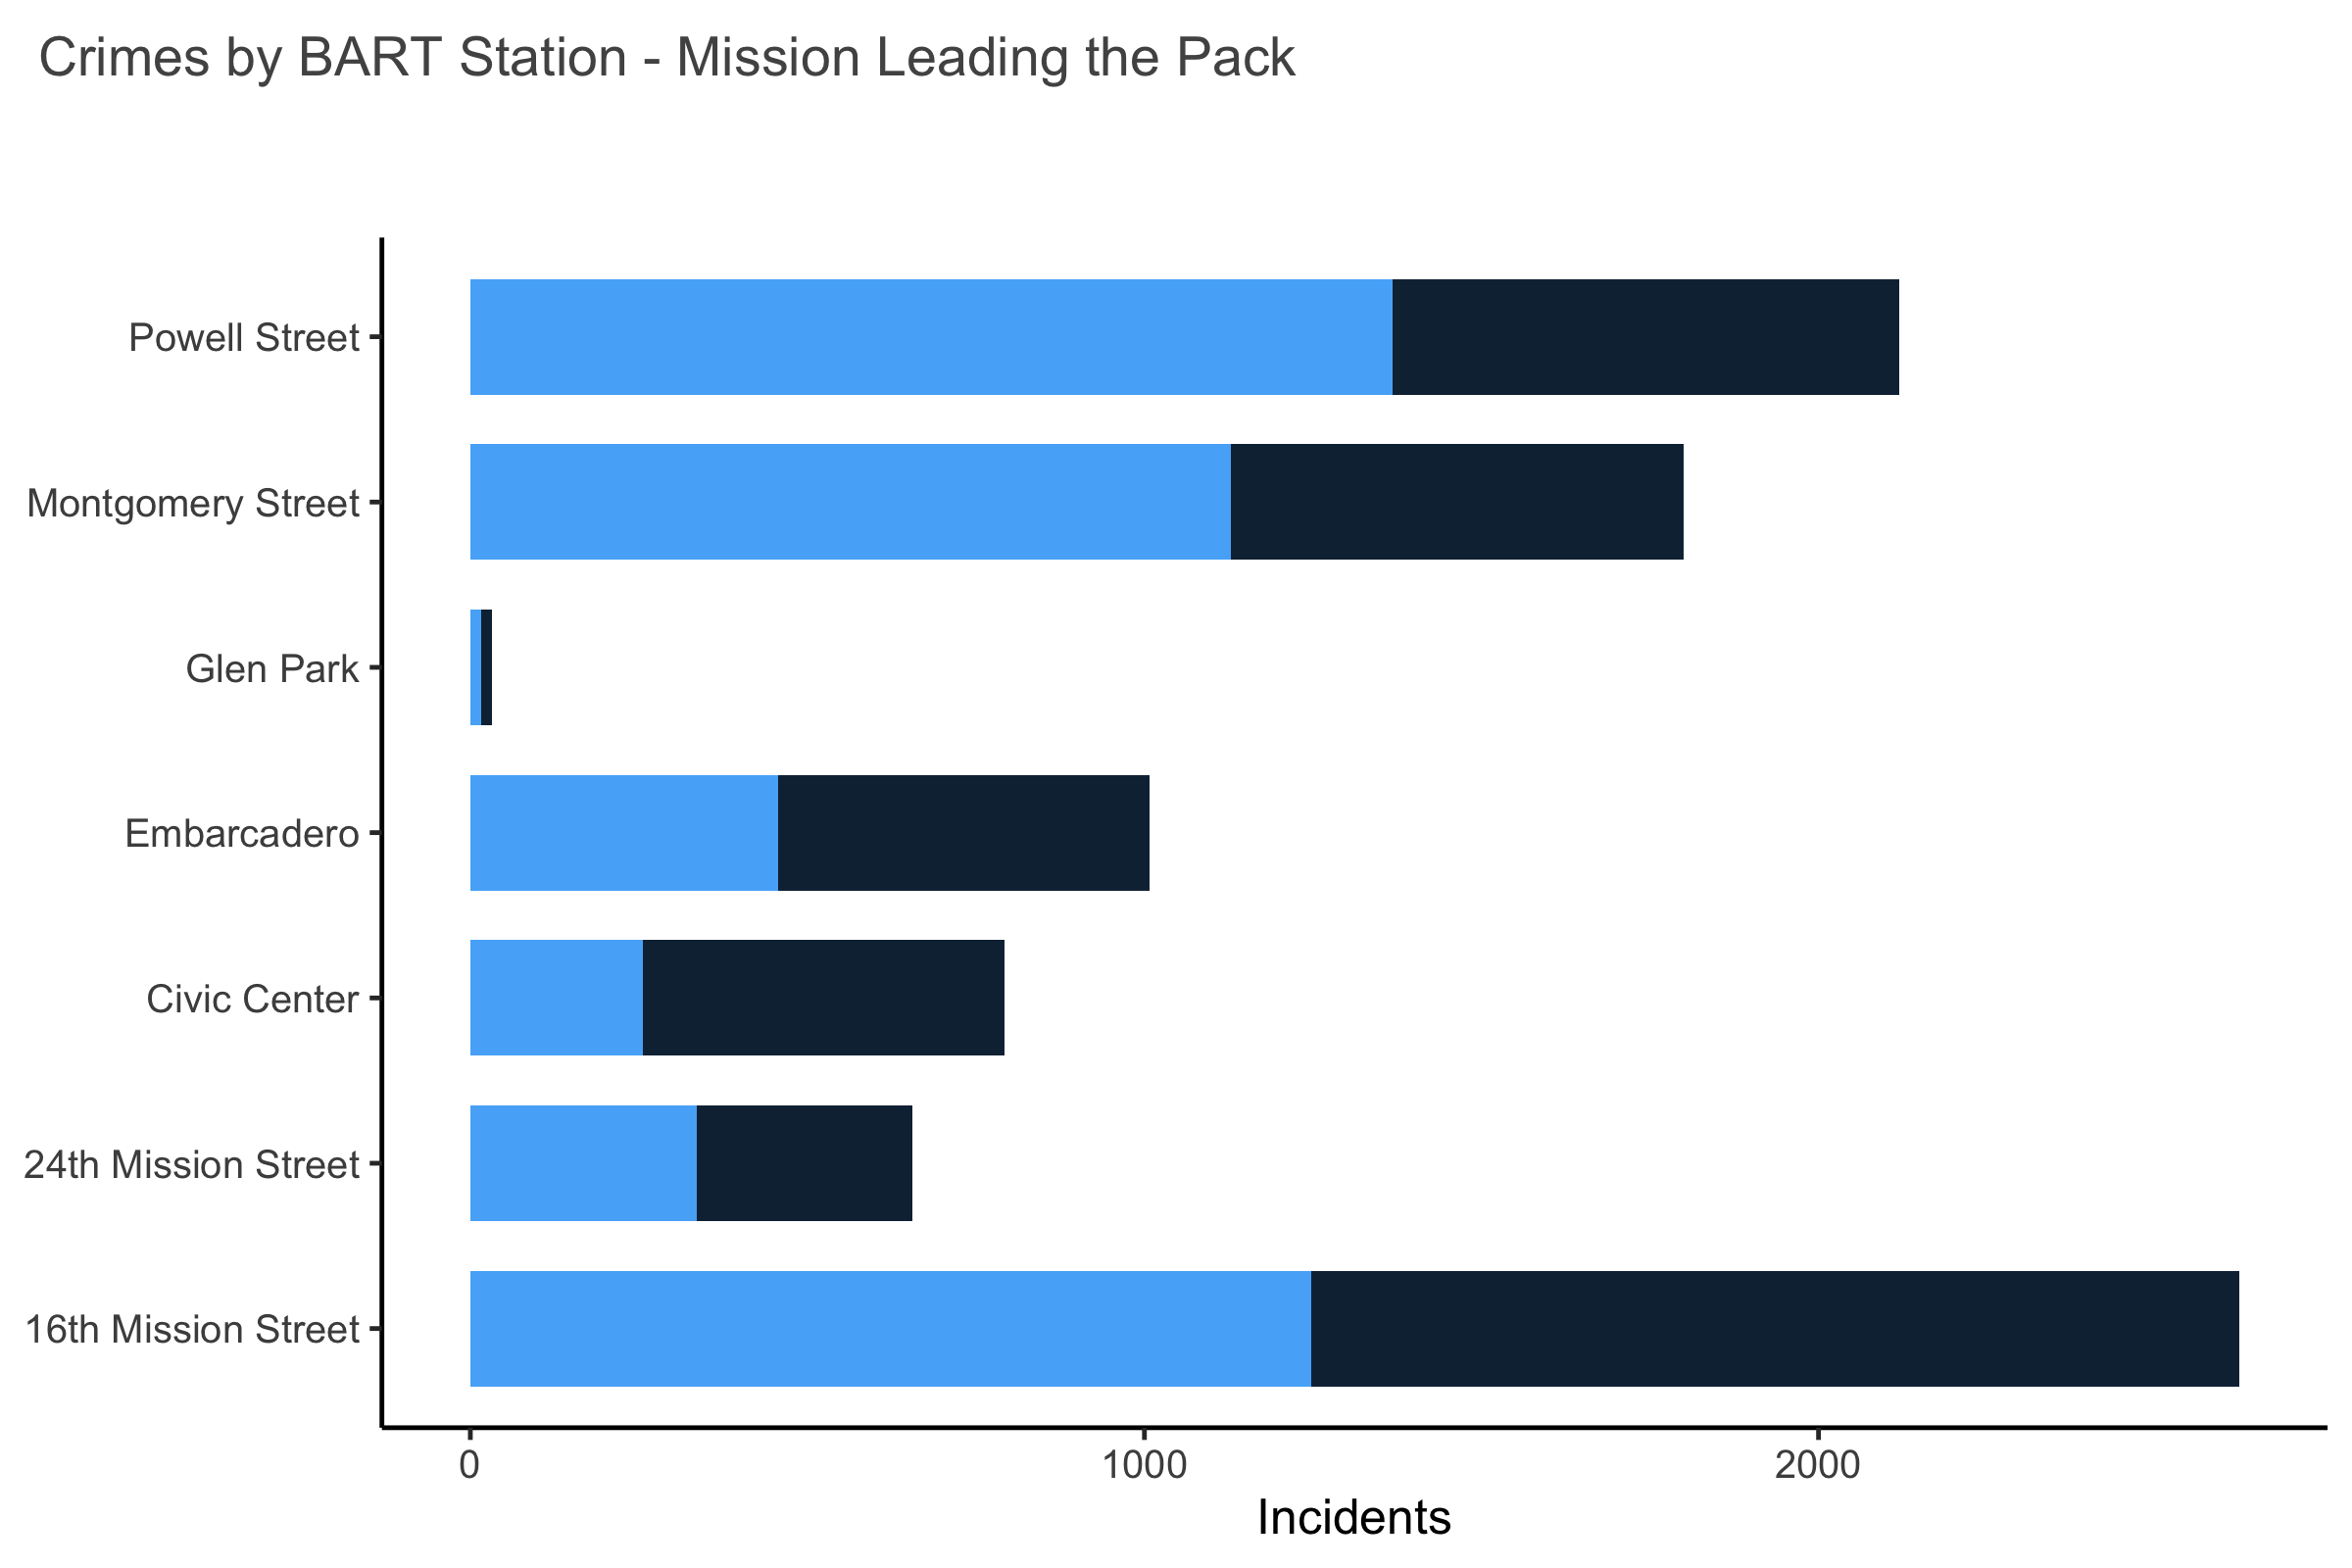

In [47]:
%%R -w 6 -h 4 --units in -r 400

ggplot() + 
geom_bar(aes(x = station_flag, y = Incidents, fill =severity, group=severity), data=df_joint_bounding_box_for_graphing_final_nonan, stat='identity',  position = position_stack(reverse = FALSE), width = .7) +
xlab('Incident') +
theme_classic(base_size=9) +
theme(axis.title.y=element_blank(), legend.text=element_text(color='grey32') , plot.title = element_text(hjust=-.5,vjust = 0, colour='grey32', size=10, margin=margin(0,0,30,0)), legend.position="none") +
ggtitle("Crimes by BART Station - Mission Leading the Pack")+

coord_flip()


In [48]:
%%R
ggsave('/Users/maxine/Documents/GitHub/Visualization/Graph3.pdf', units = 'in', width = 6, height = 4)